# Import

In [ ]:
import pandas as pd
from pyproj import Transformer
import sqlite3
from sqlite3 import Error
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
import shutil

# DataBase Process

In [ ]:
from google.colab import drive
drivePath = '/content/drive' #please do not change
drive.mount(drivePath)
dataPath = drivePath + '/MyDrive/Colab Notebooks/data' + "/"

import os, pathlib
if not(os.path.exists(dataPath)):
  # os.mkdir(dataPath) # Creates only the last directory if missing. Rises error if it exists
  path = pathlib.Path(dataPath)
  path.mkdir(parents=True, exist_ok=True) # Can create the folders in the path if missing. No error if path exists
else:
  print('The data path you selected already exists')


# Paths
RECYCLING_RAW = f"{dataPath}/Hong Kong Waste Recycling Points.csv"
FACILITIES_RAW = f"{dataPath}/Service Information of Public Places.csv"

RECYCLING_CLEAN = f"{dataPath}/Hong Kong Waste Recycling Points_cleaned.csv"
FACILITIES_LATLON = f"{dataPath}/Service Public Places_with_latlon.csv"

DB_PATH = f"{dataPath}/Smart Green Recycling Navigator.db"


# Clean Hong Kong Waste Recycling Points.csv district_id
def clean_recycling_points():
    df = pd.read_csv(RECYCLING_RAW)

    df["district_id"] = df["district_id"].astype(str)
    df["district_id"] = df["district_id"].str.replace("_", " ", regex=False)
    df["district_id"] = df["district_id"] + " District"
    df.to_csv(RECYCLING_CLEAN, index=False)
    print("✓ Cleaned district_id and saved CSV.")
    return df


# Convert Service Information of Public Places.csv EASTING / NORTHING → LAT / LON
def convert_coordinates():
    df = pd.read_csv(FACILITIES_RAW)

    if "E_DISTRICT" in df.columns:
        df["E_DISTRICT"] = (
            df["E_DISTRICT"]
            .astype(str)
            .str.replace("&", "", regex=False)
            .str.replace("  ", " ", regex=False)
            .str.strip()
            .replace("nan", None)
        )

    transformer = Transformer.from_crs("EPSG:2326", "EPSG:4326", always_xy=True)

    lons, lats = transformer.transform(
        df["EASTING"].values,
        df["NORTHING"].values
    )

    df["longitude"] = lons
    df["latitude"] = lats

    df.to_csv(FACILITIES_LATLON, index=False)
    print("✓ Converted coordinates + cleaned E_DISTRICT and saved CSV.")
    return df


# Create SQLite tables
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(f"✓ Connected to database: {db_file}")
    except Error as e:
        print(e)
    return conn


def create_table(conn, sql):
    try:
        cursor = conn.cursor()
        cursor.execute(sql)
    except Error as e:
        print("SQL Error:", e)


sql_create_districts = """
CREATE TABLE IF NOT EXISTS districts (
    district_id INTEGER PRIMARY KEY AUTOINCREMENT,
    district TEXT
);
"""

sql_create_recycling_sites = """
CREATE TABLE IF NOT EXISTS recycling_sites (
    cp_id TEXT PRIMARY KEY,
    district TEXT,
    address TEXT,
    latitude REAL,
    longitude REAL,
    accessibility_notes TEXT,
    FOREIGN KEY (district) REFERENCES districts (district)
);
"""

sql_create_site_waste_types = """
CREATE TABLE IF NOT EXISTS site_waste_types (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    cp_id TEXT,
    waste_type TEXT,
    FOREIGN KEY (cp_id) REFERENCES recycling_sites (cp_id)
);
"""

sql_create_public_facilities = """
CREATE TABLE IF NOT EXISTS public_facilities (
    sf_id TEXT PRIMARY KEY,
    district TEXT,
    class TEXT,
    address TEXT,
    latitude REAL,
    longitude REAL,
    FOREIGN KEY (district) REFERENCES districts (district)
);
"""

sql_create_report_templates_table = """
CREATE TABLE IF NOT EXISTS report_templates (
    template_id INTEGER PRIMARY KEY AUTOINCREMENT,
    template_name TEXT NOT NULL,
    template_type TEXT,
    content TEXT NOT NULL,
);
"""


# Insert CSV data into DB
def insert_districts(conn, facility_df):
    cursor = conn.cursor()

    facility_df["E_DISTRICT"] = (
        facility_df["E_DISTRICT"]
        .astype(str)
        .str.strip()
    )

    districts = facility_df["E_DISTRICT"].replace(["nan", "", "None"], pd.NA).dropna().unique()

    for d in districts:
        cursor.execute("""
            INSERT OR IGNORE INTO districts (district)
            VALUES (?)
        """, (d,))

    conn.commit()
    print("✓ Inserted districts.")


def insert_recycling_sites(conn, df):
    cursor = conn.cursor()

    for _, row in df.iterrows():
        cursor.execute("""
            INSERT OR IGNORE INTO recycling_sites
            (cp_id, district, address, latitude, longitude, accessibility_notes)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            row.get("cp_id"),
            row.get("district_id"),
            row.get("address_en"),
            row.get("lat"),
            row.get("lgt"),
            row.get("accessibilty_notes")
        ))

        waste_types = str(row.get("waste_type")).split(",")
        for w in waste_types:
            cursor.execute("""
                INSERT INTO site_waste_types (cp_id, waste_type)
                VALUES (?, ?)
            """, (row.get("cp_id"), w.strip()))

    conn.commit()
    print("✓ Inserted recycling sites and waste types.")


def insert_public_facilities(conn, df):
    cursor = conn.cursor()

    for _, row in df.iterrows():
        cursor.execute("""
            INSERT OR IGNORE INTO public_facilities
            (sf_id, district, class, address, latitude, longitude)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            row.get("GEONAMEID"),
            row.get("E_DISTRICT"),
            row.get("CLASS"),
            row.get("E_ADDRESS"),
            row.get("latitude"),
            row.get("longitude")
        ))

    conn.commit()
    print("✓ Inserted public facilities.")


# Main Workflow
def main():
    recycling_df = clean_recycling_points()
    facility_df = convert_coordinates()

    conn = create_connection(DB_PATH)

    # Create all tables
    create_table(conn, sql_create_districts)
    create_table(conn, sql_create_recycling_sites)
    create_table(conn, sql_create_site_waste_types)
    create_table(conn, sql_create_public_facilities)
    create_table(conn, sql_create_report_templates_table)

    # Insert data
    insert_districts(conn, facility_df)
    insert_recycling_sites(conn, recycling_df)
    insert_public_facilities(conn, facility_df)

    conn.close()
    print("✓ All done. Database created at:")
    print(DB_PATH)


# Run everything
main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The data path you selected already exists
✓ Cleaned district_id and saved CSV.
✓ Converted coordinates + cleaned E_DISTRICT and saved CSV.
✓ Connected to database: /content/drive/MyDrive/Colab Notebooks/data//Smart Green Recycling Navigator.db
SQL Error: near ")": syntax error
✓ Inserted districts.
✓ Inserted recycling sites and waste types.
✓ Inserted public facilities.
✓ All done. Database created at:
/content/drive/MyDrive/Colab Notebooks/data//Smart Green Recycling Navigator.db


In [ ]:
conn = sqlite3.connect(DB_PATH)

tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
display(tables)

,name
0,districts
1,sqlite_sequence
2,recycling_sites
3,site_waste_types
4,public_facilities


In [ ]:
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance (in meters) between two points on Earth.

    Parameters:
        lat1, lon1 : float or numpy array
            Latitude and longitude of the first point.
        lat2, lon2 : float or numpy array
            Latitude and longitude of the second point.

    Notes:
        - All latitude and longitude values are expected to be in decimal degrees.
        - This implementation supports both scalar values and NumPy arrays.

    Returns:
        float or numpy array
            The great-circle distance(s) in meters.
    """
    R = 6371000.0  # Earth's radius in meters
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    dlat = lat2 - lat1
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [ ]:
import re

df_sites = pd.read_sql_query("""
    SELECT cp_id, district, latitude, longitude
    FROM recycling_sites
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""", conn)

df_fac = pd.read_sql_query("""
    SELECT sf_id, district, class, latitude, longitude
    FROM public_facilities
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""", conn)

df_waste = pd.read_sql_query("""
    SELECT
        sw.waste_type,
        rs.district
    FROM site_waste_types AS sw
    JOIN recycling_sites AS rs
      ON sw.cp_id = rs.cp_id
    WHERE sw.waste_type IS NOT NULL;
""", conn)

print("Original district examples:")
print("sites:", df_sites['district'].unique()[:5])
print("fac  :", df_fac['district'].unique()[:5])
print("waste:", df_waste['district'].unique()[:5])


# Clean District Name
def clean_district(name):
    if pd.isna(name):
        return np.nan

    s = str(name).strip().lower()
    s = re.sub(r"\bdistrict\b", "", s)
    s = re.sub(r"\s+", " ", s)
    s = s.replace(" and ", " & ")
    s = s.replace("central  western", "central & western")
    s = s.replace("central western", "central & western")
    s = s.strip().title()

    mapping = {
        "Central & Western": "Central & Western District",
        "Eastern": "Eastern District",
        "Islands": "Islands District",
        "Kowloon City": "Kowloon City District",
        "Kwai Tsing": "Kwai Tsing District",
        "Kwun Tong": "Kwun Tong District",
        "North": "North District",
        "Sai Kung": "Sai Kung District",
        "Sha Tin": "Sha Tin District",
        "Sham Shui Po": "Sham Shui Po District",
        "Southern": "Southern District",
        "Tai Po": "Tai Po District",
        "Tsuen Wan": "Tsuen Wan District",
        "Tuen Mun": "Tuen Mun District",
        "Wan Chai": "Wan Chai District",
        "Wong Tai Sin": "Wong Tai Sin District",
        "Yau Tsim Mong": "Yau Tsim Mong District",
        "Yuen Long": "Yuen Long District",
    }
    return mapping.get(s, s)


df_sites['district'] = df_sites['district'].apply(clean_district)
df_fac['district']   = df_fac['district'].apply(clean_district)
df_waste['district'] = df_waste['district'].apply(clean_district)

print("\nCleaned district examples:")
print("sites:", df_sites['district'].unique()[:5])
print("fac  :", df_fac['district'].unique()[:5])
print("waste:", df_waste['district'].unique()[:5])


s = df_sites.rename(columns={'latitude':'lat_rec', 'longitude':'lon_rec'})
f = df_fac.rename(columns={'latitude':'lat_fac', 'longitude':'lon_fac'})

pairs = f.merge(s, on='district', how='inner', suffixes=('_fac','_rec'))

pairs['dist_m'] = haversine_np(
    pairs['lat_fac'].values,
    pairs['lon_fac'].values,
    pairs['lat_rec'].values,
    pairs['lon_rec'].values
)

print("\nRebuilt pairs row count:", len(pairs))


sql_recycle = """
SELECT
    district,
    COUNT(*) AS recycling_points
FROM recycling_sites
GROUP BY district
ORDER BY district;
"""

sql_facility = """
SELECT
    district,
    COUNT(*) AS facilities
FROM public_facilities
GROUP BY district
ORDER BY district;
"""

recycle_counts = pd.read_sql_query(sql_recycle, conn).set_index('district')['recycling_points']
facility_counts = pd.read_sql_query(sql_facility, conn).set_index('district')['facilities']

summary = pd.concat([recycle_counts, facility_counts], axis=1).fillna(0).astype(int)

summary = summary.reset_index()
summary = summary.dropna(subset=['district'])
summary = summary[summary['district'] != 'None']
summary = summary.set_index('district')

print("\nCleaned summary (district-level):")
display(summary.sort_index())

Original district examples:
sites: ['Kwai Tsing District' 'Tuen Mun District' 'Yuen Long District'
 'North District' 'Tai Po District']
fac  : ['Tsuen Wan District' 'Sham Shui Po District' 'North District'
 'Wong Tai Sin District' 'Tuen Mun District']
waste: ['Kwai Tsing District' 'Tuen Mun District' 'Yuen Long District'
 'North District' 'Tai Po District']

Cleaned district examples:
sites: ['Kwai Tsing District' 'Tuen Mun District' 'Yuen Long District'
 'North District' 'Tai Po District']
fac  : ['Tsuen Wan District' 'Sham Shui Po District' 'North District'
 'Wong Tai Sin District' 'Tuen Mun District']
waste: ['Kwai Tsing District' 'Tuen Mun District' 'Yuen Long District'
 'North District' 'Tai Po District']

Rebuilt pairs row count: 18661883

Cleaned summary (district-level):


,recycling_points,facilities
district,,
Central Western District,681,1735
Eastern District,567,1909
Islands District,353,2291
Kowloon City District,536,1676
Kwai Tsing District,429,2205
Kwun Tong District,536,2165
North District,444,2161
Sai Kung District,633,2279
Sha Tin District,660,2682


# Report Templates

In [ ]:
DB_PATH = "/content/drive/MyDrive/Colab Notebooks/data/Smart Green Recycling Navigator.db"

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS report_templates (
    template_id INTEGER PRIMARY KEY AUTOINCREMENT,
    template_name TEXT NOT NULL,
    template_type TEXT NOT NULL,
    content TEXT NOT NULL,
    UNIQUE(template_name)
)
""")
conn.commit()

templates = [
    # 4 reports
    ("Waste Type Coverage Insight", "visualized_report",
     "In our dataset, {waste_type} accounts for about {share_pct:.1f}% of all recorded recycling-capacity entries across sites."),

    ("District Average Distance Insight", "visualized_report",
     "In {district}, public facilities are on average about {avg_distance:.0f} meters away from the nearest recycling site."),

    ("Facility Class Convenience Insight", "visualized_report",
     "For {facility_class}, there are on average {avg_500:.1f} recycling sites within 500 meters and {avg_1000:.1f} within 1 kilometer."),

    ("District Correlation Insight", "visualized_report",
     "In {district}, there are {recycling_count} recycling points serving {facilities_count} public facilities."),

    # 5 queries
    ("Matching Facilities Card", "search_by_facilities",
     """<div class="facility-info">
    <h3>Facility {{index}} <span class="facility-count">ID: {{id}}</span></h3>
    <p><strong>Type:</strong> {{type_full}} <span class="type-badge">{{type_code}}</span></p>
    <p><strong>Name:</strong> {{name}}</p>
    <p><strong>Address:</strong> {{address}}</p>
    <p><strong>District:</strong> {{district}}</p>
    <p><strong>Coordinates:</strong> <span class="coordinates">{{lat}}, {{lon}}</span></p>
    <button class="btn" onclick="displayFacilityWithNearbyRecyclingById('{{id}}')">
        Find Nearest 5 Recycling Sites
    </button>
</div>"""),

    ("Nearest Recycling Site Card", "search_by_facilities",
     """<div class="recycling-site within-1km">
    <h3>Recycling Site #{{rank}} <span class="distance-badge">{{distance}} km</span></h3>
    <div class="distance-info">Distance from Facility: {{distance}} km</div>
    <div class="distance-meter"><div class="distance-fill" style="width: {{percentage}}%;"></div></div>
    <p><strong>Site ID:</strong> {{id}}</p>
    <p><strong>Address:</strong> {{address}}</p>
    <p><strong>District:</strong> {{district}}</p>
    <p><strong>Accessibility:</strong> <span class="accessibility">{{accessibility}}</span></p>
    <p><strong>Coordinates:</strong> <span class="coordinates">{{lat}}, {{lon}}</span></p>
</div>"""),

    ("Statistics Summary Card", "search_by_facilities",
     """<div class="stats">
    <h3>Nearest 5 Recycling Sites Statistics</h3>
    <p><strong>Total displayed:</strong> <span style="color:var(--orange);font-weight:bold">{{total}}</span></p>
    <p><strong>Within 1km:</strong> <span style="color:var(--orange);font-weight:bold">{{within_1km}}</span></p>
    <p><strong>Closest:</strong> <span style="color:var(--orange);font-weight:bold">{{closest}} km</span></p>
    <p><strong>Average distance:</strong> <span style="color:var(--orange);font-weight:bold">{{average}} km</span></p>
</div>"""),

    ("Query Results Title", "search_by_waste_type",
     """<div id="resultsTitle">Recycling points that accept "{{waste_types}}"{{district_filter}}</div>"""),

    ("Recycling Point Card", "search_by_waste_type",
     """<div class="recycling-point">
    <div class="point-header"><h3>{{district}}</h3><div class="point-id">{{id}}</div></div>
    <div class="point-details">
        <div><span class="detail-label">Address:</span> {{address}}</div>
        <div><span class="detail-label">Coord:</span> ({{latitude}}, {{longitude}})</div>
    </div>
    <div class="waste-types"><strong>Acceptable Waste Types:</strong> {{waste_types_joined}}</div>
    <div class="accessibility"><strong>Accessibility Notes:</strong> {{accessibility}}</div>
</div>""")
]

cursor.executemany("""
INSERT OR IGNORE INTO report_templates (template_name, template_type, content)
VALUES (?, ?, ?)
""", templates)

conn.commit()

cursor.execute("SELECT template_id, template_name, template_type FROM report_templates ORDER BY template_id")
print("template_id    template_name                               template_type")
for row in cursor.fetchall():
    print(f"{row[0]:<14} {row[1]:<42} {row[2]}")

conn.close()

template_id    template_name                               template_type
1              Waste Type Coverage Insight                visualized_report
2              District Average Distance Insight          visualized_report
3              Facility Class Convenience Insight         visualized_report
4              District Correlation Insight               visualized_report
5              Matching Facilities Card                   search_by_facilities
6              Nearest Recycling Site Card                search_by_facilities
7              Statistics Summary Card                    search_by_facilities
8              Query Results Title                        search_by_waste_type
9              Recycling Point Card                       search_by_waste_type


# Map

In [24]:
import folium
from folium import plugins
import pandas as pd
import sqlite3
from IPython.display import display, HTML

print("Database Path:", DB_PATH)


conn = sqlite3.connect(DB_PATH)
recycling_df = pd.read_sql_query("""
    SELECT rs.*, GROUP_CONCAT(swt.waste_type) AS types_str
    FROM recycling_sites rs
    LEFT JOIN site_waste_types swt ON rs.cp_id = swt.cp_id
    GROUP BY rs.cp_id
""", conn)
facilities_df = pd.read_sql_query("SELECT * FROM public_facilities", conn)
conn.close()

recycling_df['waste_types'] = recycling_df['types_str'].fillna('').apply(
    lambda x: [t.strip() for t in x.split(',') if t.strip()]
)
all_waste_types = sorted({t for sub in recycling_df['waste_types'] for t in sub})

# Convert Class Full Name
class_full_name = {
    'PAK': 'Park', 'AQU': 'Swimming Pool', 'BGD': 'Beach / Garden', 'BUS': 'Bus Terminus',
    'RSF': 'Rest Garden', 'COM': 'Community Hall', 'CMF': 'Community Facility',
    'CUF': 'Cultural Facility', 'GOV': 'Government Building', 'HNC': 'Historic Building',
    'MUF': 'Museum', 'REM': 'Remote Area', 'SCH': 'School', 'TRF': 'Traffic Facility',
    'TRH': 'Train Station (MTR)', 'TRS': 'Train Station (Light Rail)',
    'AMD': 'Amenity', 'UTI': 'Utility Facility'
}

PUBLIC_COLOR      = "#2980b9"
PUBLIC_FILL       = "#3498db"
FACILITY_COLOR    = "#9333ea"
FACILITY_FILL     = "#c084fc"
RECYCLE_COLOR     = "#1abc9c"
RECYCLE_BORDER    = "#16a085"
WASTE_COLOR       = "#e67e22"
WASTE_BORDER      = "#e74c3c"


m = folium.Map(location=[22.3193, 114.1694], zoom_start=11.6, tiles="CartoDB positron")

title_html = '''
<h3 align="center" style="font-size:26px;font-weight:bold;margin:0;color:white;background:#18AC8F;padding:18px 0;border:none;outline:none;">
    Hong Kong Smart Recycling Navigator<br>
    <small style="font-size:16px;color:white;font-weight:normal;">Making Hong Kong a Greener City Through Data Intelligence</small>
</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# 1. All Public Facilities（Open）
fg_all_fac = folium.FeatureGroup(name="All Public Facilities", show=True)
for _, row in facilities_df.iterrows():
    code = row['class'] if pd.notna(row['class']) else "Unknown"
    full_name = class_full_name.get(code, code)
    addr = str(row['address']) if pd.notna(row['address']) and row['address'] else "No address"
    addr_short = (addr[:47] + '...') if len(addr) > 50 else addr

    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=4.5,
        color=PUBLIC_COLOR,
        weight=1.8,
        fillColor=PUBLIC_FILL,
        fillOpacity=0.88,
        popup=folium.Popup(f"<b style='color:#2980b9'>{full_name}</b><br>{addr_short}", max_width=300),
        tooltip=f"<strong>{full_name}</strong>"
    ).add_to(fg_all_fac)
fg_all_fac.add_to(m)

#  2. Specific Public Facilities（Close）
for class_code in sorted(facilities_df['class'].dropna().unique()):
    full_name = class_full_name.get(class_code, class_code)
    sub_df = facilities_df[facilities_df['class'] == class_code]
    fg = folium.FeatureGroup(name=full_name, show=False)

    for _, row in sub_df.iterrows():
        addr = str(row['address']) if pd.notna(row['address']) and row['address'] else "No address"
        addr_short = (addr[:47] + '...') if len(addr) > 50 else addr

        folium.CircleMarker(
            location=[row.latitude, row.longitude],
            radius=4,
            color=FACILITY_COLOR,
            weight=1.5,
            fillColor=FACILITY_FILL,
            fillOpacity=0.9,
            popup=folium.Popup(f"<b style='color:#2980b9'>{full_name}</b><br>{addr_short}", max_width=300),
            tooltip=f"<strong>{full_name}</strong>"
        ).add_to(fg)
    fg.add_to(m)

# 3. All Recycling Points（Open)
fg_all_rec = folium.FeatureGroup(name="All Recycling Points", show=True)
for _, row in recycling_df.iterrows():
    addr = str(row.get('address', '')) if pd.notna(row.get('address')) else "Recycling Point"
    types = ", ".join(row.waste_types) if row.waste_types else "General"

    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=4.5,
        color=RECYCLE_BORDER,
        weight=1.8,
        fillColor=RECYCLE_COLOR,
        fillOpacity=0.92,
        popup=folium.Popup(f"<b style='color:#27ae60'>{addr}</b><br>{types}", max_width=300),
        tooltip="<strong>Recycling Point</strong>"
    ).add_to(fg_all_rec)
fg_all_rec.add_to(m)

# 4. 2. Specific Recycling Points（Close）
for wt in all_waste_types:
    sub = recycling_df[recycling_df.waste_types.apply(lambda x: wt in x)]
    fg = folium.FeatureGroup(name=f"{wt} Recycling", show=False)

    for _, row in sub.iterrows():
        addr = str(row.get('address', '')) if pd.notna(row.get('address')) else "Point"
        folium.CircleMarker(
            location=[row.latitude, row.longitude],
            radius=4,
            color=WASTE_BORDER,
            weight=1.5,
            fillColor=WASTE_COLOR,
            fillOpacity=0.94,
            popup=folium.Popup(f"<b style='color:#e74c3c'>{addr}</b><br>{wt}", max_width=300),
            tooltip=f"<strong>{wt}</strong>"
        ).add_to(fg)
    fg.add_to(m)

# 5. Heatmap
plugins.HeatMap(recycling_df[["latitude","longitude"]].values.tolist(),
                name="Recycling Density Heatmap", radius=16, blur=22, show=False).add_to(m)


# Legend html
legend_html = '''
<div style="position:fixed; bottom:20px; left:20px; width:280px; background:rgba(255,255,255,0.98);
     border-radius:16px; box-shadow:0 6px 30px rgba(0,0,0,0.35); z-index:9999; padding:18px; font-family:Arial;">
  <b style="font-size:16px;color:#2c3e50;">Map Legend</b><br><br>
  <i style="background:#3498db; width:14px; height:14px; border-radius:50%; display:inline-block; border:2.5px solid #2980b9;"></i>
  <span style="margin-left:8px;">All Public Facilities</span><br><br>

  <i style="background:#c084fc; width:14px; height:14px; border-radius:50%; display:inline-block; border:2.5px solid #9333ea;"></i>
  <span style="margin-left:8px;">Specific Facility Class</span><br><br>

  <i style="background:#1abc9c; width:15px; height:15px; border-radius:50%; display:inline-block; border:3px solid #16a085;"></i>
  <span style="margin-left:8px;">All Recycling Points</span><br><br>

  <i style="background:#e67e22; width:16px; height:16px; border-radius:50%; display:inline-block; border:2.5px solid #e74c3c;"></i>
  <span style="margin-left:8px;">Specific Waste Type</span><br><br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl(collapsed=False).add_to(m)
plugins.Fullscreen().add_to(m)
plugins.MousePosition(position='bottomright').add_to(m)

# Save
map_path = f"{dataPath}/Hong_Kong_Recycling_Map.html"
m.save(map_path)
print(f"map path: {map_path}")

Database Path: /content/drive/MyDrive/Colab Notebooks/data/Smart Green Recycling Navigator.db
map path: /content/drive/MyDrive/Colab Notebooks/data//Hong_Kong_Recycling_Map.html
Buffered data was truncated after reaching the output size limit.

# Smart Recycling Finder

## Smart Recycling Finder: By Nearby Facility

In [ ]:
# query recycling points and public facilities in each district
conn = sqlite3.connect(DB_PATH)

districts_df = pd.read_sql("SELECT DISTINCT district FROM districts ORDER BY district", conn)
facility_types_df = pd.read_sql("SELECT DISTINCT class FROM public_facilities WHERE class IS NOT NULL ORDER BY class", conn)

facilities_df = pd.read_sql("""
    SELECT sf_id, district, class, address, latitude, longitude
    FROM public_facilities
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""", conn)

recycling_sites_df = pd.read_sql("""
    SELECT rs.cp_id, rs.district, rs.address, rs.latitude, rs.longitude,
           rs.accessibility_notes, GROUP_CONCAT(swt.waste_type) as waste_types
    FROM recycling_sites rs
    LEFT JOIN site_waste_types swt ON rs.cp_id = swt.cp_id
    WHERE rs.latitude IS NOT NULL AND rs.longitude IS NOT NULL
    GROUP BY rs.cp_id
""", conn)

recycling_count = pd.read_sql("SELECT COUNT(*) as count FROM recycling_sites", conn).iloc[0]['count']
facility_count = pd.read_sql("SELECT COUNT(*) as count FROM public_facilities", conn).iloc[0]['count']

conn.close()

# creat district options
district_options = ""
for _, row in districts_df.iterrows():
    district = row['district']
    if district and district != 'None' and str(district) != 'nan':
        district_options += f'<option value="{district}">{district}</option>\n'

class_full_name = {
    'PAK': 'Park', 'AQU': 'Swimming Pool', 'BGD': 'Beach / Garden', 'BUS': 'Bus Terminus',
    'RSF': 'Rest Garden', 'COM': 'Community Hall', 'CMF': 'Community Facility',
    'CUF': 'Cultural Facility', 'GOV': 'Government Building', 'HNC': 'Historic Building',
    'MUF': 'Museum', 'REM': 'Remote Area', 'SCH': 'School', 'TRF': 'Traffic Facility',
    'TRH': 'Train Station (MTR)', 'TRS': 'Train Station (Light Rail)',
    'AMD': 'Amenity', 'UTI': 'Utility Facility'
}

facility_type_options = ""
for _, row in facility_types_df.iterrows():
    facility_type = row['class']
    if facility_type:
        full_name = class_full_name.get(facility_type, facility_type)
        facility_type_options += f'<option value="{facility_type}">{full_name}</option>\n'

facilities_data = []
for _, row in facilities_df.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        facilities_data.append({
            'id': str(row['sf_id']),
            'name': str(row['address']),
            'type': str(row['class']) if pd.notna(row['class']) else "Unknown",
            'address': str(row['address']) if pd.notna(row['address']) else "Unknown Address",
            'district': str(row['district']) if pd.notna(row['district']) else "Unknown District",
            'coordinates': [float(row['latitude']), float(row['longitude'])]
        })

recycling_sites_data = []
for _, row in recycling_sites_df.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        recycling_sites_data.append({
            'id': str(row['cp_id']),
            'address': str(row['address']) if pd.notna(row['address']) else "Unknown Address",
            'district': str(row['district']) if pd.notna(row['district']) else "Unknown District",
            'coordinates': [float(row['latitude']), float(row['longitude'])],
            'wasteTypes': str(row['waste_types']) if pd.notna(row['waste_types']) else "Not specified",
            'accessibility': str(row['accessibility_notes']) if pd.notna(row['accessibility_notes']) else "Standard access"
        })

In [ ]:
html_content = f'''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Smart Green Recycling Navigator - Interactive Query</title>
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700&display=swap" rel="stylesheet">
    <style>
        :root {{
            --green: #1abc9c;
            --orange: #e67e22;
            --dark: #2c3e50;
            --light: #f8fff9;
        }}
        * {{ margin:0; padding:0; box-sizing:border-box; }}
        body {{
            font-family: 'Poppins', sans-serif;
            background: #f8fff9;
            color: var(--dark);
            line-height: 1.7;
        }}
        header {{
            background: linear-gradient(135deg, var(--green), #16a085);
            color: white;
            text-align: center;
            padding: 80px 20px 60px;
        }}
        header h1 {{
            font-size: 44px;
            font-weight: 700;
            margin-bottom: 12px;
        }}
        header p {{
            font-size: 20px;
            opacity: 0.95;
        }}
        .container {{
            max-width: 1100px;
            margin: 0 auto;
            padding: 60px 20px;
        }}
        /* 已删除 .stats 的所有样式 */
        h2 {{
            color: var(--green);
            font-size: 30px;
            text-align: center;
            margin: 50px 0 40px;
        }}
        .form-group {{
            margin-bottom: 25px;
        }}
        label {{
            display: block;
            margin-bottom: 10px;
            font-weight: 600;
            color: var(--dark);
            font-size: 17px;
        }}
        select, input {{
            width: 100%;
            padding: 14px;
            border: 2px solid #ddd;
            border-radius: 12px;
            font-size: 16px;
            transition: all 0.3s;
        }}
        select:focus, input:focus {{
            outline: none;
            border-color: var(--green);
            box-shadow: 0 0 0 4px rgba(26,188,156,0.15);
        }}
        .btn {{
            display: block;
            width: 100%;
            padding: 16px;
            background: var(--green);
            color: white;
            border: none;
            border-radius: 12px;
            font-size: 18px;
            font-weight: 600;
            cursor: pointer;
            transition: all 0.3s;
            margin: 30px 0;
        }}
        .btn:hover {{
            background: #16a085;
            transform: translateY(-2px);
        }}
        .btn-secondary {{
            background: #3498db;
        }}
        .btn-secondary:hover {{
            background: #2980b9;
        }}
        .facility-info, .recycling-site {{
            background: white;
            padding: 25px;
            border-radius: 16px;
            margin: 20px 0;
            box-shadow: 0 10px 30px rgba(0,0,0,0.08);
            transition: all 0.4s;
        }}
        .facility-info:hover, .recycling-site:hover {{
            transform: translateY(-8px);
            box-shadow: 0 18px 40px rgba(0,0,0,0.14);
        }}
        .facility-info {{
            border-left: 6px solid #3498db;
        }}
        .recycling-site {{
            border-left: 6px solid var(--orange);
        }}
        .distance-badge {{
            background: var(--green);
            color: white;
            padding: 6px 12px;
            border-radius: 20px;
            font-size: 14px;
            font-weight: bold;
            display: inline-block;
            margin-left: 10px;
        }}
        .distance-info {{
            background: #3498db;
            color: white;
            padding: 10px 14px;
            border-radius: 10px;
            font-size: 15px;
            font-weight: bold;
            display: inline-block;
            margin: 8px 0;
        }}
        .type-badge {{
            background: #9b59b6;
            color: white;
            padding: 4px 10px;
            border-radius: 12px;
            font-size: 13px;
            margin-left: 8px;
        }}
        .coordinates {{
            font-family: monospace;
            background: #f1f2f6;
            padding: 6px 12px;
            border-radius: 8px;
            font-size: 14px;
        }}
        .accessibility {{
            color: #27ae60;
            font-weight: bold;
        }}
        .distance-meter {{
            width: 100%;
            height: 12px;
            background: #ecf0f1;
            border-radius: 8px;
            margin: 12px 0;
            overflow: hidden;
        }}
        .distance-fill {{
            height: 100%;
            background: linear-gradient(90deg, #2ecc71, #f1c40f, #e74c3c);
            border-radius: 8px;
        }}
        .within-1km {{
            border: 3px solid #2ecc71;
        }}
        .loading, .error {{
            text-align: center;
            padding: 30px;
            background: white;
            border-radius: 16px;
            margin: 20px 0;
            box-shadow: 0 10px 30px rgba(0,0,0,0.08);
        }}
        .error {{
            border-left: 6px solid #e74c3c;
        }}
        footer {{
            background: var(--dark);
            color: #bdc3c7;
            text-align: center;
            padding: 50px 20px;
            margin-top: 100px;
            font-size: 15px;
        }}
        .result-section {{
            display: none;
            margin-top: 40px;
        }}
    </style>
</head>
<body>

<header>
    <h1>Smart Green Recycling Navigator</h1>
    <p>Interactive Facility & Recycling Sites Query System</p>
</header>

<div class="container">
    <!-- 彻底删除了整个 .stats 板块 -->
    <h2>Query Facilities and Nearby Recycling Sites</h2>

    <div class="form-group">
        <label for="district">Select District:</label>
        <select id="district">
            <option value="">-- Select a District --</option>
            {district_options}
        </select>
    </div>

    <div class="form-group">
        <label for="searchType">Search Method:</label>
        <select id="searchType">
            <option value="name">Search by Facility Name</option>
            <option value="type">Search by Facility Type</option>
        </select>
    </div>

    <div class="form-group" id="nameSearchGroup">
        <label for="facilityName">Facility Name (supports partial matching):</label>
        <input type="text" id="facilityName" placeholder="e.g. Community Centre, Park, School">
    </div>

    <div class="form-group" id="typeSearchGroup">
        <label for="facilityType">Facility Type:</label>
        <select id="facilityType">
            <option value="">-- Select a Facility Type --</option>
            {facility_type_options}
        </select>
    </div>

    <button class="btn" onclick="searchFacilities()">Search Facilities</button>

    <div id="loading" class="loading" style="display: none;">
        <p>Searching for facilities... Please wait.</p>
    </div>

    <div id="errorMessage" class="error" style="display: none;"></div>

    <div id="facilitiesResult" class="result-section">
        <h2>Matching Facilities</h2>
        <div id="facilitiesList"></div>
    </div>

    <div id="recyclingResult" class="result-section">
        <h2>Nearby Recycling Sites</h2>
        <div id="selectedFacility"></div>
        <div id="recyclingSitesList"></div>
        <div id="statistics" class="stats"></div>
    </div>

    <div style="text-align:center;margin:50px 0;">
        <button class="btn btn-secondary" onclick="resetForm()">New Search</button>
    </div>
</div>

<footer>
    <p><strong>Smart Green Recycling Navigator</strong> • November 2025</p>
    <p><em>Making Hong Kong a Greener City Through Data Intelligence</em></p>
</footer>

<script>
    const realFacilities = {json.dumps(facilities_data, ensure_ascii=False)};
    const realRecyclingSites = {json.dumps(recycling_sites_data, ensure_ascii=False)};
    const classFullName = {json.dumps(class_full_name, ensure_ascii=False)};
    function getFacilityTypeFullName(typeCode) {{
        return classFullName[typeCode] || typeCode;
    }}
    function calculateDistance(lat1, lon1, lat2, lon2) {{
        const R = 6371;
        const dLat = (lat2 - lat1) * Math.PI / 180;
        const dLon = (lon2 - lon1) * Math.PI / 180;
        const a =
            Math.sin(dLat/2) * Math.sin(dLat/2) +
            Math.cos(lat1 * Math.PI / 180) * Math.cos(lat2 * Math.PI / 180) *
            Math.sin(dLon/2) * Math.sin(dLon/2);
        const c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));
        return R * c;
    }}
    function toggleSearchType() {{
        const searchType = document.getElementById('searchType').value;
        if (searchType === 'name') {{
            document.getElementById('nameSearchGroup').style.display = 'block';
            document.getElementById('typeSearchGroup').style.display = 'none';
        }} else {{
            document.getElementById('nameSearchGroup').style.display = 'none';
            document.getElementById('typeSearchGroup').style.display = 'block';
        }}
    }}
    function initPage() {{
        document.getElementById('searchType').addEventListener('change', toggleSearchType);
        toggleSearchType();
    }}
    document.addEventListener('DOMContentLoaded', initPage);
    function searchFacilities() {{
        const district = document.getElementById('district').value;
        const searchType = document.getElementById('searchType').value;
        if (!district) {{
            alert('Please select a district');
            return;
        }}
        if (searchType === 'type') {{
            const facilityType = document.getElementById('facilityType').value;
            if (!facilityType) {{
                alert('Please select a facility type');
                return;
            }}
        }}
        document.getElementById('loading').style.display = 'block';
        document.getElementById('errorMessage').style.display = 'none';
        document.getElementById('facilitiesResult').style.display = 'none';
        document.getElementById('recyclingResult').style.display = 'none';
        setTimeout(() => {{
            document.getElementById('loading').style.display = 'none';
            let facilities = realFacilities.filter(f => f.district === district);
            if (facilities.length === 0) {{
                document.getElementById('errorMessage').style.display = 'block';
                document.getElementById('errorMessage').innerHTML =
                    '<p>No facilities found in the selected district. Please try a different district.</p>';
                return;
            }}
            if (searchType === 'name') {{
                const facilityName = document.getElementById('facilityName').value.toLowerCase();
                if (facilityName) {{
                    facilities = facilities.filter(f =>
                        f.name.toLowerCase().includes(facilityName) ||
                        f.address.toLowerCase().includes(facilityName)
                    );
                }}
                if (facilities.length === 1) {{
                    displayFacilityWithNearbyRecycling(facilities[0]);
                    return;
                }}
            }} else {{
                const facilityType = document.getElementById('facilityType').value;
                facilities = facilities.filter(f => f.type === facilityType);
            }}
            if (facilities.length === 0) {{
                document.getElementById('errorMessage').style.display = 'block';
                document.getElementById('errorMessage').innerHTML =
                    '<p>No facilities found matching your criteria. Please try different search terms.</p>';
                return;
            }}
            displayFacilities(facilities);
        }}, 500);
    }}
    function displayFacilities(facilities) {{
        const facilitiesList = document.getElementById('facilitiesList');
        facilitiesList.innerHTML = '';
        facilities.forEach((facility, index) => {{
            const facilityDiv = document.createElement('div');
            facilityDiv.className = 'facility-info';
            const typeFullName = getFacilityTypeFullName(facility.type);
            facilityDiv.innerHTML =
                '<h3>Facility ' + (index + 1) + ' <span class="facility-count">ID: ' + facility.id + '</span></h3>' +
                '<p><strong>Type:</strong> ' + typeFullName + ' <span class="type-badge">' + facility.type + '</span></p>' +
                '<p><strong>Name:</strong> ' + facility.name + '</p>' +
                '<p><strong>Address:</strong> ' + facility.address + '</p>' +
                '<p><strong>District:</strong> ' + facility.district + '</p>' +
                '<p><strong>Coordinates:</strong> <span class="coordinates">' + facility.coordinates[0].toFixed(6) + ', ' + facility.coordinates[1].toFixed(6) + '</span></p>' +
                '<button class="btn" onclick="displayFacilityWithNearbyRecyclingById(\\'' + facility.id + '\\')">Find Nearest 5 Recycling Sites</button>';
            facilitiesList.appendChild(facilityDiv);
        }});
        document.getElementById('facilitiesResult').style.display = 'block';
    }}
    function displayFacilityWithNearbyRecyclingById(facilityId) {{
        const facility = realFacilities.find(f => f.id === facilityId);
        if (facility) {{
            displayFacilityWithNearbyRecycling(facility);
        }} else {{
            alert('Facility not found!');
        }}
    }}
    function displayFacilityWithNearbyRecycling(facility) {{
        const typeFullName = getFacilityTypeFullName(facility.type);
        document.getElementById('selectedFacility').innerHTML =
            '<div class="facility-info">' +
                '<h3>Selected Facility: ' + facility.name + ' <span class="facility-count">ID: ' + facility.id + '</span></h3>' +
                '<p><strong>Type:</strong> ' + typeFullName + ' <span class="type-badge">' + facility.type + '</span></p>' +
                '<p><strong>Name:</strong> ' + facility.name + '</p>' +
                '<p><strong>Address:</strong> ' + facility.address + '</p>' +
                '<p><strong>District:</strong> ' + facility.district + '</p>' +
                '<p><strong>Coordinates:</strong> <span class="coordinates">' + facility.coordinates[0].toFixed(6) + ', ' + facility.coordinates[1].toFixed(6) + '</span></p>' +
            '</div>';
        const recyclingSitesWithDistance = realRecyclingSites.map(site => {{
            const distance = calculateDistance(
                facility.coordinates[0], facility.coordinates[1],
                site.coordinates[0], site.coordinates[1]
            );
            return {{ ...site, distance: distance }};
        }});
        const nearestRecyclingSites = recyclingSitesWithDistance
            .sort((a, b) => a.distance - b.distance)
            .slice(0, 5);
        displayRecyclingSites(nearestRecyclingSites, facility);
        document.getElementById('facilitiesResult').style.display = 'none';
        document.getElementById('recyclingResult').style.display = 'block';
        document.getElementById('recyclingResult').scrollIntoView({{ behavior: 'smooth' }});
    }}
    function displayRecyclingSites(recyclingSites, selectedFacility) {{
        const recyclingSitesList = document.getElementById('recyclingSitesList');
        recyclingSitesList.innerHTML = '';
        if (recyclingSites.length === 0) {{
            recyclingSitesList.innerHTML = '<div class="error"><p>No recycling sites found near the selected facility.</p></div>';
            return;
        }}
        const maxDistance = Math.max(...recyclingSites.map(site => site.distance));
        recyclingSites.forEach((site, index) => {{
            const siteDiv = document.createElement('div');
            siteDiv.className = 'recycling-site within-1km';
            const distancePercentage = Math.min((site.distance / maxDistance) * 100, 100);
            siteDiv.innerHTML =
                '<h3>Recycling Site #' + (index + 1) + ' <span class="distance-badge">' + site.distance.toFixed(2) + ' km</span></h3>' +
                '<div class="distance-info">Distance from Facility: ' + site.distance.toFixed(2) + ' km</div>' +
                '<div class="distance-meter"><div class="distance-fill" style="width: ' + distancePercentage + '%;"></div></div>' +
                '<p><strong>Site ID:</strong> ' + site.id + '</p>' +
                '<p><strong>Address:</strong> ' + site.address + '</p>' +
                '<p><strong>District:</strong> ' + site.district + '</p>' +
                '<p><strong>Accessibility:</strong> <span class="accessibility">' + site.accessibility + '</span></p>' +
                '<p><strong>Coordinates:</strong> <span class="coordinates">' + site.coordinates[0].toFixed(6) + ', ' + site.coordinates[1].toFixed(6) + '</span></p>';
            recyclingSitesList.appendChild(siteDiv);
        }});
        const totalDistance = recyclingSites.reduce((sum, site) => sum + site.distance, 0);
        const averageDistance = totalDistance / recyclingSites.length;
        const within1kmCount = recyclingSites.filter(site => site.distance <= 1).length;
        document.getElementById('statistics').innerHTML =
            '<h3>Nearest 5 Recycling Sites Statistics</h3>' +
            '<p><strong>Total sites displayed:</strong> <span style="color:var(--orange);font-weight:bold">' + recyclingSites.length + '</span></p>' +
            '<p><strong>Sites within 1km:</strong> <span style="color:var(--orange);font-weight:bold">' + within1kmCount + '</span></p>' +
            '<p><strong>Closest site:</strong> <span style="color:var(--orange);font-weight:bold">' + recyclingSites[0].distance.toFixed(2) + ' km</span></p>' +
            '<p><strong>Farthest site displayed:</strong> <span style="color:var(--orange);font-weight:bold">' + recyclingSites[recyclingSites.length - 1].distance.toFixed(2) + ' km</span></p>' +
            '<p><strong>Average distance:</strong> <span style="color:var(--orange);font-weight:bold">' + averageDistance.toFixed(2) + ' km</span></p>';
    }}
    function resetForm() {{
        document.getElementById('district').value = '';
        document.getElementById('searchType').value = 'name';
        document.getElementById('facilityName').value = '';
        document.getElementById('facilityType').value = '';
        document.getElementById('facilitiesResult').style.display = 'none';
        document.getElementById('recyclingResult').style.display = 'none';
        document.getElementById('errorMessage').style.display = 'none';
        toggleSearchType();
        window.scrollTo({{ top: 0, behavior: 'smooth' }});
    }}
</script>
</body>
</html>
'''

output_path = f"{dataPath}/Smart_Recycling_Finder:_By_Nearby_Facility.html"
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"File saved: {output_path}")

File saved: /content/drive/MyDrive/Colab Notebooks/data//Smart_Recycling_Finder:_By_Nearby_Facility.html


## Smart Recycling Finder: By Waste Category

In [ ]:
# query waste type
def get_waste_types_from_db():
    conn = create_connection(DB_PATH)
    if conn is None:
        return ["Paper", "Plastic", "Glass", "Metal", "Electronics"]
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT DISTINCT waste_type FROM site_waste_types ORDER BY waste_type")
        waste_types = [row[0] for row in cursor.fetchall()]
        conn.close()
        return waste_types
    except Error as e:
        print(f"Database error: {e}")
        return ["Paper", "Plastic", "Glass", "Metal", "Electronics"]

def get_districts_from_db():
    conn = create_connection(DB_PATH)
    if conn is None:
        return ["Central and Western", "Eastern", "Southern", "Wan Chai", "Sham Shui Po",
               "Kowloon City", "Kwun Tong", "Wong Tai Sin", "Yau Tsim Mong", "Islands",
               "Kwai Tsing", "North", "Sai Kung", "Sha Tin", "Tai Po", "Tsuen Wan", "Tuen Mun", "Yuen Long"]
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT DISTINCT district FROM recycling_sites WHERE district IS NOT NULL AND district != '' ORDER BY district")
        districts = [row[0] for row in cursor.fetchall()]
        conn.close()
        return districts
    except Error as e:
        print(f"Database error: {e}")
        return ["Central and Western", "Eastern", "Southern", "Wan Chai", "Sham Shui Po",
               "Kowloon City", "Kwun Tong", "Wong Tai Sin", "Yau Tsim Mong", "Islands",
               "Kwai Tsing", "North", "Sai Kung", "Sha Tin", "Tai Po", "Tsuen Wan", "Tuen Mun", "Yuen Long"]

def get_recycling_sites_from_db():
    conn = create_connection(DB_PATH)
    if conn is None:
        return []
    try:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT
                rs.cp_id,
                rs.district,
                rs.address,
                rs.latitude,
                rs.longitude,
                rs.accessibility_notes,
                GROUP_CONCAT(swt.waste_type) as waste_types
            FROM recycling_sites rs
            JOIN site_waste_types swt ON rs.cp_id = swt.cp_id
            GROUP BY rs.cp_id
        """)
        points = []
        for row in cursor.fetchall():
            cp_id, district, address, lat, lng, accessibility_notes, waste_types_str = row
            waste_types = waste_types_str.split(',') if waste_types_str else []

            if accessibility_notes:
                note_prefixes = ["Note:", "note:", "NOTE:", "Note：", "note：", "NOTE："]
                cleaned = accessibility_notes.strip()
                for prefix in note_prefixes:
                    if cleaned.startswith(prefix):
                        cleaned = cleaned[len(prefix):].strip()
                        break
                accessibility = cleaned if cleaned else "no special instructions"
            else:
                accessibility = "no special instructions"

            points.append({
                "id": cp_id,
                "district": district,
                "address": address,
                "latitude": lat,
                "longitude": lng,
                "accessibility": accessibility,
                "waste_types": waste_types
            })
        conn.close()
        return points
    except Error as e:
        print(f"Database error: {e}")
        return []

actual_waste_types = get_waste_types_from_db()
actual_districts   = get_districts_from_db()
actual_recycling_points = get_recycling_sites_from_db()

waste_types_json      = json.dumps(actual_waste_types)
districts_json        = json.dumps(actual_districts)
recycling_points_json = json.dumps(actual_recycling_points)

✓ Connected to database: /content/drive/MyDrive/Colab Notebooks/data//Smart Green Recycling Navigator.db
✓ Connected to database: /content/drive/MyDrive/Colab Notebooks/data//Smart Green Recycling Navigator.db
✓ Connected to database: /content/drive/MyDrive/Colab Notebooks/data//Smart Green Recycling Navigator.db


In [ ]:
html_content = f'''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Smart Green Recycling Navigator - Waste Recycling Site Query System</title>
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700&display=swap" rel="stylesheet">
    <style>
        :root {{--green:#1abc9c;--orange:#e67e22;--dark:#2c3e50;--light:#f8fff9;}}
        * {{margin:0;padding:0;box-sizing:border-box;}}
        body {{font-family:'Poppins',sans-serif;background:#f8fff9;color:var(--dark);line-height:1.7;}}
        header {{background:linear-gradient(135deg,var(--green),#16a085);color:white;text-align:center;padding:90px 20px 70px;}}
        header h1 {{font-size:46px;font-weight:700;margin-bottom:16px;}}
        header .subtitle {{font-size:21px;opacity:0.92;}}
        .container {{max-width:1160px;margin:0 auto;padding:60px 20px;}}
        .query-section,.results-section {{background:white;border-radius:18px;padding:35px;margin:30px 0;
            box-shadow:0 12px 35px rgba(0,0,0,0.09);border-left:6px solid var(--green);}}
        h2 {{color:var(--green);font-size:32px;text-align:center;margin:50px 0 40px;}}
        .stats {{background:var(--light);padding:25px;border-radius:16px;text-align:center;
            border-left:6px solid var(--green);font-size:17px;margin:30px 0;}}
        .stats-number {{font-size:42px;font-weight:700;color:var(--green);}}
        .waste-type-grid,.district-grid {{display:grid;grid-template-columns:repeat(auto-fill,minmax(180px,1fr));
            gap:15px;margin:30px 0;}}
        .waste-type-btn,.district-btn {{background:var(--green);color:white;border:none;padding:16px;
            border-radius:12px;font-weight:600;cursor:pointer;transition:all 0.3s;font-size:15px;}}
        .district-btn {{background:#3498db;}}
        .waste-type-btn:hover,.district-btn:hover {{transform:translateY(-4px);box-shadow:0 10px 20px rgba(0,0,0,0.15);}}
        .waste-type-btn.selected {{background:var(--orange);transform:scale(1.05);}}
        .district-btn.selected {{background:#9b59b6;transform:scale(1.05);}}
        .selected-types,.selected-districts {{display:flex;flex-wrap:wrap;gap:12px;padding:20px;
            background:var(--light);border-radius:12px;border:2px dashed var(--green);min-height:60px;}}
        .selected-districts {{border:2px dashed #3498db;}}
        .selected-type,.selected-district {{background:var(--orange);color:white;padding:10px 18px;
            border-radius:30px;font-weight:600;display:flex;gap:10px;align-items:center;}}
        .selected-district {{background:#9b59b6;}}
        .remove-type {{background:none;border:none;color:white;font-size:20px;cursor:pointer;}}
        .btn {{display:block;width:100%;padding:18px;background:var(--green);color:white;border:none;
            border-radius:12px;font-size:18px;font-weight:600;cursor:pointer;transition:all 0.3s;margin:20px 0;}}
        .btn:hover {{background:#16a085;transform:translateY(-2px);}}
        .btn.waste {{background:var(--orange);}}
        .btn.waste:hover {{background:#d35400;}}
        .btn.secondary {{background:#95a5a6;}}
        .btn.secondary:hover {{background:#7f8c8d;}}
        .recycling-point {{background:white;padding:28px;border-radius:16px;margin:20px 0;
            box-shadow:0 10px 30px rgba(0,0,0,0.08);border-left:6px solid var(--orange);transition:0.4s;}}
        .recycling-point:hover {{transform:translateY(-8px);box-shadow:0 18px 40px rgba(0,0,0,0.14);}}
        .point-header {{display:flex;justify-content:space-between;align-items:center;margin-bottom:20px;}}
        .point-id {{background:var(--orange);color:white;padding:8px 16px;border-radius:30px;font-weight:bold;}}
        .point-details {{display:grid;grid-template-columns:1fr 1fr;gap:20px;margin-bottom:15px;}}
        .detail-label {{font-weight:600;color:var(--dark);width:120px;display:inline-block;}}
        .waste-types,.accessibility {{padding:15px;border-radius:10px;margin:15px 0;}}
        .waste-types {{background:#f8fff9;border-left:5px solid var(--green);}}
        .accessibility {{background:#fff9f5;border-left:5px solid var(--orange);font-style:italic;}}
        .message {{padding:20px;border-radius:12px;text-align:center;font-weight:bold;margin:20px 0;}}
        .message.warning {{background:#fff3cd;color:#856404;border:1px solid #ffeaa7;}}
        footer {{background:var(--dark);color:#bdc3c7;text-align:center;padding:50px 20px;margin-top:100px;font-size:15px;}}
        @media (max-width:768px){{.point-details{{grid-template-columns:1fr;}}}}
    </style>
</head>
<body>

<header>
    <h1>Smart Green Recycling Navigator</h1>
    <p class="subtitle">Hong Kong Waste Type Recycling Site Query System</p>
</header>

<div class="container">

    <div class="query-section">
        <h2>Select Waste Types for Query</h2>

        <div class="stats">
            <div class="stats-number">{len(actual_recycling_points)}</div>
            <div>{len(actual_recycling_points)} Recycling Points • {len(actual_waste_types)} Waste Types • {len(actual_districts)} Districts</div>
        </div>

        <div id="selectedTypes" class="selected-types">
            <div style="color:#7f8c8d;width:100%;text-align:center;font-style:italic;">No waste types selected yet</div>
        </div>

        <div id="wasteTypeGrid" class="waste-type-grid"></div>

        <div style="text-align:center;margin:30px 0;">
            <button class="btn" onclick="queryRecyclingSites()">Query Recycling Sites</button>
            <button class="btn secondary" onclick="clearSelection()">Clear Selection</button>
        </div>
    </div>

    <div class="results-section" id="resultsSection" style="display:none;">
        <h2>Query Results</h2>

        <div class="query-section">
            <h3>Filter by District</h3>
            <div id="selectedDistricts" class="selected-districts">
                <div style="color:#7f8c8d;width:100%;text-align:center;font-style:italic;">Click district buttons below to filter</div>
            </div>
            <div id="districtGrid" class="district-grid"></div>
            <div style="text-align:center;margin:30px 0;">
                <button class="btn" onclick="applyDistrictFilter()">Apply District Filter</button>
                <button class="btn secondary" onclick="clearDistrictSelection()">Clear District Selection</button>
                <button class="btn secondary" onclick="showAllPoints()">Show All Results</button>
            </div>
        </div>

        <div id="resultsStats" class="stats">
            <div class="stats-number" id="resultsCount">0</div>
            <div id="resultsTitle">Recycling Points</div>
        </div>

        <div id="recyclingPoints"></div>
    </div>

</div>

<footer>
    <p><strong>Smart Green Recycling Navigator</strong> • November 2025</p>
    <p><em>Making Hong Kong a Greener City Through Data Intelligence</em></p>
</footer>

<script>
    const wasteTypes = {waste_types_json};
    const districts = {districts_json};
    const recyclingPoints = {recycling_points_json};

    let selectedWasteTypes = [];
    let selectedDistricts = [];
    let currentFilteredPoints = [];

    document.addEventListener('DOMContentLoaded', () => initializeWasteTypes());

    function initializeWasteTypes() {{
        const g = document.getElementById('wasteTypeGrid'); g.innerHTML = '';
        wasteTypes.sort().forEach(t => {{
            const b = document.createElement('button');
            b.className = 'waste-type-btn'; b.textContent = t;
            b.onclick = () => toggleWasteType(t); g.appendChild(b);
        }});
    }}

    function initializeDistricts() {{
        const g = document.getElementById('districtGrid'); g.innerHTML = '';
        districts.sort().forEach(d => {{
            const b = document.createElement('button');
            b.className = 'district-btn'; b.textContent = d;
            b.onclick = () => toggleDistrict(d); g.appendChild(b);
        }});
    }}

    function toggleWasteType(t) {{
        const i = selectedWasteTypes.indexOf(t);
        i===-1 ? selectedWasteTypes.push(t) : selectedWasteTypes.splice(i,1);
        updateSelectedTypesDisplay(); updateWasteTypeButtons();
    }}

    function toggleDistrict(d) {{
        const i = selectedDistricts.indexOf(d);
        i===-1 ? selectedDistricts.push(d) : selectedDistricts.splice(i,1);
        updateSelectedDistrictsDisplay(); updateDistrictButtons();
    }}

    function updateSelectedTypesDisplay() {{
        const c = document.getElementById('selectedTypes'); c.innerHTML = '';
        if(!selectedWasteTypes.length) c.innerHTML = '<div style="color:#7f8c8d;width:100%;text-align:center;font-style:italic;">No waste types selected yet</div>';
        selectedWasteTypes.forEach(t=>{{
            const b=document.createElement('div'); b.className='selected-type';
            b.innerHTML = `${{t}}<button class="remove-type" onclick="removeWasteType('${{t}}')">×</button>`;
            c.appendChild(b);
        }});
    }}

    function updateSelectedDistrictsDisplay() {{
        const c = document.getElementById('selectedDistricts'); c.innerHTML = '';
        if(!selectedDistricts.length) c.innerHTML = '<div style="color:#7f8c8d;width:100%;text-align:center;font-style:italic;">Click district buttons below to filter</div>';
        selectedDistricts.forEach(d=>{{
            const b=document.createElement('div'); b.className='selected-district';
            b.innerHTML = `${{d}}<button class="remove-type" onclick="removeDistrict('${{d}}')">×</button>`;
            c.appendChild(b);
        }});
    }}

    function removeWasteType(t) {{ selectedWasteTypes=selectedWasteTypes.filter(x=>x!==t); updateSelectedTypesDisplay(); updateWasteTypeButtons(); }}
    function removeDistrict(d)   {{ selectedDistricts=selectedDistricts.filter(x=>x!==d);   updateSelectedDistrictsDisplay(); updateDistrictButtons(); }}

    function updateWasteTypeButtons() {{ document.querySelectorAll('.waste-type-btn').forEach(b=>b.classList.toggle('selected',selectedWasteTypes.includes(b.textContent))); }}
    function updateDistrictButtons()   {{ document.querySelectorAll('.district-btn').forEach(b=>b.classList.toggle('selected',selectedDistricts.includes(b.textContent))); }}

    function clearSelection() {{ selectedWasteTypes=[]; updateSelectedTypesDisplay(); updateWasteTypeButtons(); }}
    function clearDistrictSelection() {{ selectedDistricts=[]; updateSelectedDistrictsDisplay(); updateDistrictButtons(); }}

    function queryRecyclingSites() {{
        if(!selectedWasteTypes.length){{alert('Please select at least one waste type');return;}}
        currentFilteredPoints = recyclingPoints.filter(p=>selectedWasteTypes.every(t=>p.waste_types.includes(t)));
        displayResults(currentFilteredPoints);
    }}

    function applyDistrictFilter() {{
        if(!selectedDistricts.length){{alert('Please select at least one district');return;}}
        const f = currentFilteredPoints.filter(p=>selectedDistricts.includes(p.district));
        displayFilteredResults(f);
    }}

    function showAllPoints() {{ selectedDistricts=[]; updateSelectedDistrictsDisplay(); updateDistrictButtons(); displayResults(currentFilteredPoints); }}

    function displayResults(pts) {{
        document.getElementById('resultsCount').textContent = pts.length;
        document.getElementById('resultsTitle').textContent =
            selectedWasteTypes.length===1 ? `Recycling points that accept "${{selectedWasteTypes[0]}}"`.replace(/"/g,'') :
            `Recycling points that accept all of: "${{selectedWasteTypes.join(' + ')}}"`;
        renderPoints(pts); initializeDistricts(); clearDistrictSelection();
        document.getElementById('resultsSection').style.display='block';
        document.getElementById('resultsSection').scrollIntoView({{behavior:'smooth'}});
    }}

    function displayFilteredResults(pts) {{
        document.getElementById('resultsCount').textContent = pts.length;
        document.getElementById('resultsTitle').textContent =
            `Recycling points that accept "${{selectedWasteTypes.join(' + ')}}" in ${{selectedDistricts.join(', ')}}`;
        renderPoints(pts);
    }}

    function renderPoints(pts) {{
        const c = document.getElementById('recyclingPoints'); c.innerHTML='';
        if(!pts.length){{c.innerHTML='<div class="message warning">No matching recycling points found<br><small>Please try other combinations</small></div>';return;}}
        pts.forEach(p=>{{
            const d=document.createElement('div'); d.className='recycling-point';
            d.innerHTML = `
                <div class="point-header"><h3>${{p.district}}</h3><div class="point-id">${{p.id}}</div></div>
                <div class="point-details">
                    <div><span class="detail-label">Address:</span> ${{p.address}}</div>
                    <div><span class="detail-label">Coord:</span> (${{p.latitude}}, ${{p.longitude}})</div>
                </div>
                <div class="waste-types"><strong>Acceptable Waste Types:</strong> ${{p.waste_types.join(', ')}}</div>
                <div class="accessibility"><strong>Accessibility Notes:</strong> ${{p.accessibility}}</div>`;
            c.appendChild(d);
        }});
    }}
</script>
</body>
</html>
'''

html_file_path = f"{dataPath}/Smart_Recycling_Finder:_By_Waste_Category.html"
with open(html_file_path, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"HTML file generated: {html_file_path}")
print(f"Includes {len(actual_waste_types)} waste types and {len(actual_recycling_points)} recycling points")

try:
    from google.colab import files
    print("\nTo download: files.download(html_file_path)")
except: pass

HTML file generated: /content/drive/MyDrive/Colab Notebooks/data//Smart_Recycling_Finder:_By_Waste_Category.html
Includes 16 waste types and 8858 recycling points

To download: files.download(html_file_path)


# Visualization

## Coverage of Different Waste Types Across Recycling Sites

The number of recycling points for various types of waste：


,waste_type,site_count
0,Metals,6254
1,Plastics,6036
2,Paper,5957
3,Glass Bottles,2789
4,Rechargeable Batteries,2343
5,Fluorescent Lamp,1665
6,Food Waste,1569
7,Small Electrical and Electronic Equipment,961
8,Beverage Cartons,953
9,Plastic Bottle,787


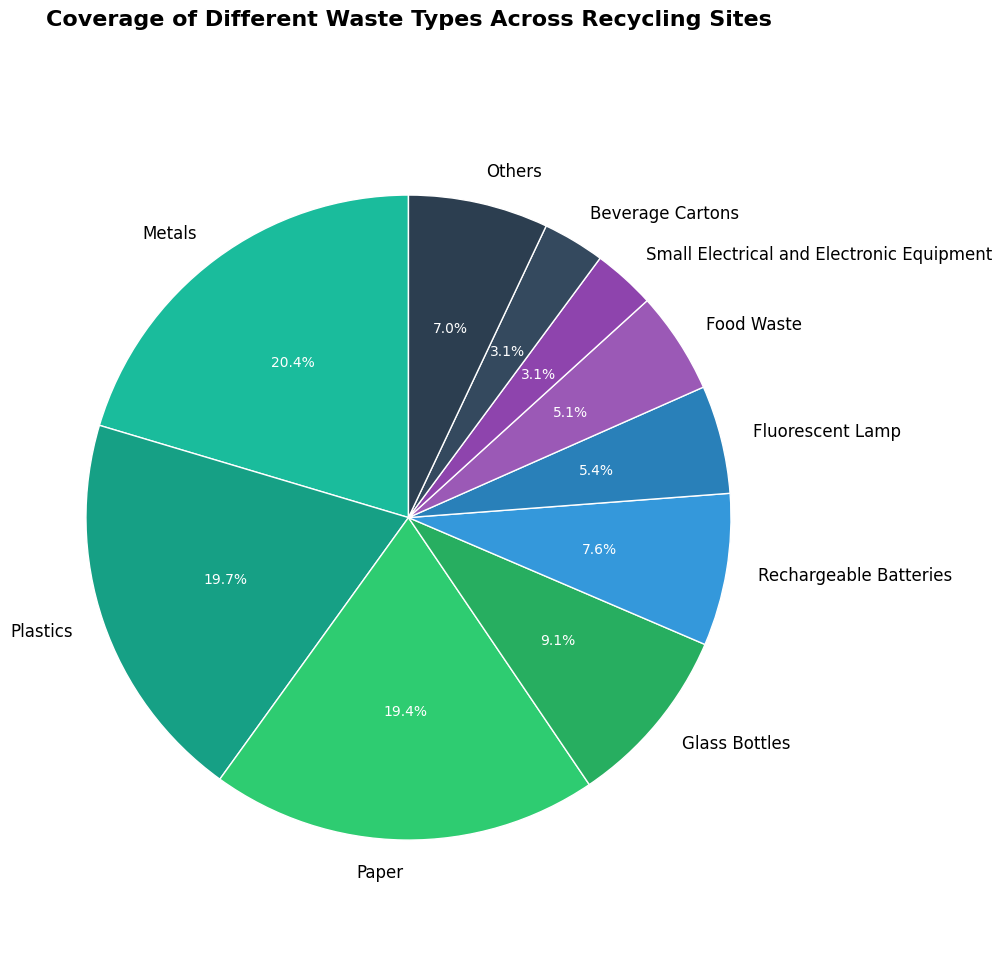

Saved optimized waste-type pie chart to: /content/drive/MyDrive/Colab Notebooks/data/Coverage of Different Waste Types Across Recycling Sites.png


,waste_type,site_count,share_pct
0,Metals,6254,20.4
1,Plastics,6036,19.7
2,Paper,5957,19.4
3,Glass Bottles,2789,9.1
4,Rechargeable Batteries,2343,7.6
5,Fluorescent Lamp,1665,5.4
6,Food Waste,1569,5.1
7,Small Electrical and Electronic Equipment,961,3.1
8,Beverage Cartons,953,3.1
9,Plastic Bottle,787,2.6


In [26]:
conn = sqlite3.connect(DB_PATH)

sql_waste = """
SELECT
    sw.waste_type,
    COUNT(*) AS site_count
FROM site_waste_types AS sw
JOIN recycling_sites AS rs
    ON sw.cp_id = rs.cp_id
WHERE sw.waste_type IS NOT NULL
GROUP BY sw.waste_type
ORDER BY site_count DESC;
"""
df_waste = pd.read_sql_query(sql_waste, conn)

print("The number of recycling points for various types of waste：")
display(df_waste)

threshold = 3.0
waste_counts = df_waste.set_index('waste_type')["site_count"]
total = waste_counts.sum()
waste_pct = waste_counts / total * 100


small = waste_pct[waste_pct < threshold]
if not small.empty:
    waste_pct = waste_pct[waste_pct >= threshold]
    waste_pct['Others'] = small.sum()


colors = ['#1abc9c', '#16a085', '#2ecc71', '#27ae60', '#3498db', '#2980b9',
          '#9b59b6', '#8e44ad', '#34495e', '#2c3e50', '#7f8c8d']

plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    waste_pct,
    labels=waste_pct.index,
    autopct=lambda pct: f'{pct:.1f}%' if pct >= 3 else '',
    startangle=90,
    colors=colors[:len(waste_pct)],
    textprops={'fontsize': 12, 'fontweight': 'medium'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)

plt.title("Coverage of Different Waste Types Across Recycling Sites",
          fontsize=16, fontweight='bold', pad=30)
plt.axis('equal')
plt.tight_layout()

waste_fig_path = dataPath + "Coverage of Different Waste Types Across Recycling Sites.png"
plt.savefig(waste_fig_path, dpi=200, bbox_inches='tight')

plt.show()
print("Saved optimized waste-type pie chart to:", waste_fig_path)


total_sites = df_waste['site_count'].sum()
df_waste['share_pct'] = (df_waste['site_count'] / total_sites * 100).round(1)
display(df_waste[['waste_type', 'site_count', 'share_pct']])

## Average Distance from Public Facility to Nearest Recycling Site by District

In [27]:
print("Recycling sites:", df_sites.shape)
print("Public facilities:", df_fac.shape)

print("pairs example:")
display(pairs.head())

Recycling sites: (8858, 4)
Public facilities: (37427, 5)
pairs example:


,sf_id,district,class,lat_fac,lon_fac,cp_id,lat_rec,lon_rec,dist_m
0,555863,Tsuen Wan District,HNC,22.369546,114.11956,1311,22.372260,114.096753,2364.455718
1,555863,Tsuen Wan District,HNC,22.369546,114.11956,1316,22.378990,114.125880,1234.984126
2,555863,Tsuen Wan District,HNC,22.369546,114.11956,1317,22.379068,114.124908,1193.130092
3,555863,Tsuen Wan District,HNC,22.369546,114.11956,1318,22.394952,114.107231,3096.400771
4,555863,Tsuen Wan District,HNC,22.369546,114.11956,1320,22.366616,114.063932,5729.362216


In [28]:
pairs[['sf_id', 'cp_id', 'dist_m']].to_sql(
    "pairs_dist", conn, if_exists="replace", index=False
)

18661883

Average shortest distance from public facilities to nearest recycling site (meters):


,district,avg_min_dist_m
0,Islands District,540.789237
1,North District,332.774976
2,Tsuen Wan District,280.383812
3,Sai Kung District,273.870389
4,Tuen Mun District,239.076086
5,Tai Po District,212.429434
6,Yuen Long District,163.046248
7,Southern District,161.135159
8,Kwai Tsing District,156.212471
9,Sha Tin District,105.626541


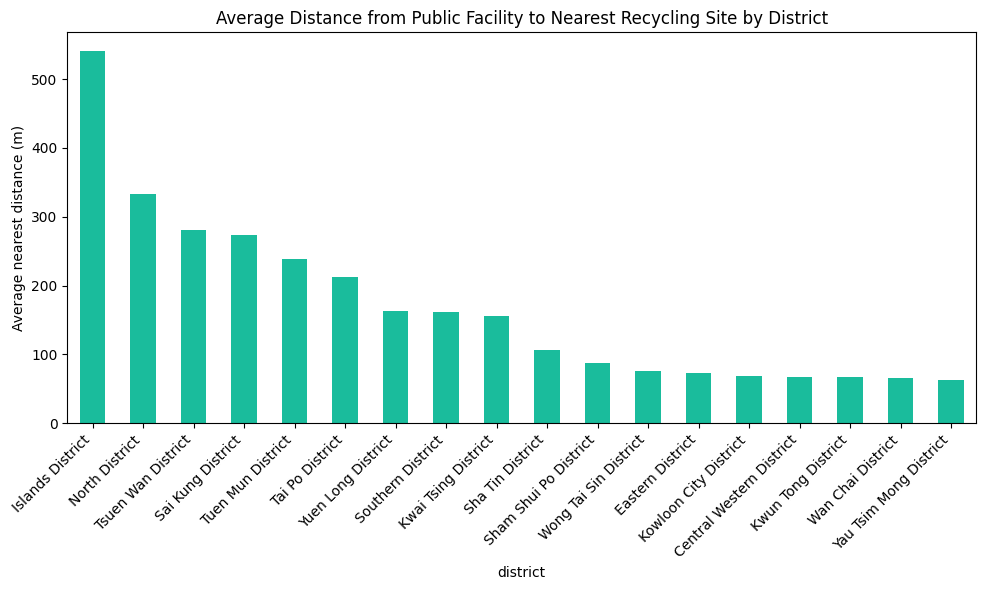

'Top 5 least convenient districts:'

,avg_min_dist_m
district,
Islands District,540.789237
North District,332.774976
Tsuen Wan District,280.383812
Sai Kung District,273.870389
Tuen Mun District,239.076086


'Top 5 most convenient districts:'

,avg_min_dist_m
district,
Yau Tsim Mong District,63.142591
Wan Chai District,65.029881
Kwun Tong District,66.775459
Central Western District,67.562615
Kowloon City District,68.319922


,district,avg_distance
0,Islands District,541
1,North District,333
2,Tsuen Wan District,280
3,Sai Kung District,274
4,Tuen Mun District,239
5,Tai Po District,212
6,Yuen Long District,163
7,Southern District,161
8,Kwai Tsing District,156
9,Sha Tin District,106


In [29]:
sql_facility_dist = """
SELECT
    f.district,
    AVG(t.min_dist_m) AS avg_min_dist_m
FROM (
    SELECT
        sf_id,
        MIN(dist_m) AS min_dist_m
    FROM pairs_dist
    GROUP BY sf_id
) AS t
JOIN public_facilities AS f
    ON t.sf_id = f.sf_id
GROUP BY f.district
ORDER BY avg_min_dist_m DESC;
"""

df_avg_dist = pd.read_sql_query(sql_facility_dist, conn)

print("Average shortest distance from public facilities to nearest recycling site (meters):")
display(df_avg_dist)

avg_dist_by_dist = df_avg_dist.set_index("district")["avg_min_dist_m"]


plt.figure(figsize=(10,6))
avg_dist_by_dist.plot(kind='bar', color='#1abc9c')
plt.ylabel("Average nearest distance (m)")
plt.title("Average Distance from Public Facility to Nearest Recycling Site by District")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

fac_fig_path = dataPath + "Average Distance from Public Facility to Nearest Recycling Site by District.png"
plt.savefig(fac_fig_path, dpi=150)

plt.show()

display("Top 5 least convenient districts:")
display(avg_dist_by_dist.head(5))

display("Top 5 most convenient districts:")
display(avg_dist_by_dist.tail(5).sort_values())


df_avg_dist['avg_distance'] = df_avg_dist['avg_min_dist_m'].round(0).astype(int)
display(df_avg_dist[['district', 'avg_distance']])

## Recycling Convenience by Facility Type

In [30]:
pairs['within_500'] = pairs['dist_m'] <= 500
pairs['within_1000'] = pairs['dist_m'] <= 1000

pairs[['sf_id', 'within_500', 'within_1000']].to_sql(
    "pairs_buffer", conn, if_exists="replace", index=False)

18661883

Recycling Convenience by Facility Type:


,facility_type,avg_sites_500m,avg_sites_1000m,coverage_500m,coverage_1000m,total_facilities
0,Amenity,49.57,127.47,99.0%,99.5%,1838
1,Historic Building,48.45,130.97,99.8%,100.0%,1178
2,Community Facility,45.08,123.82,99.3%,99.7%,3067
3,School,39.71,112.85,99.9%,100.0%,3794
4,Remote Area,36.98,104.10,94.2%,98.1%,1974
5,Government Building,36.45,107.60,96.6%,98.1%,2147
6,Bus Terminus,31.59,92.44,96.8%,98.8%,1387
7,Community Hall,31.11,87.41,97.8%,98.3%,818
8,Train Station (Light Rail),31.01,92.01,89.5%,92.7%,3076
9,Rest Garden,29.37,88.85,94.1%,97.3%,7952


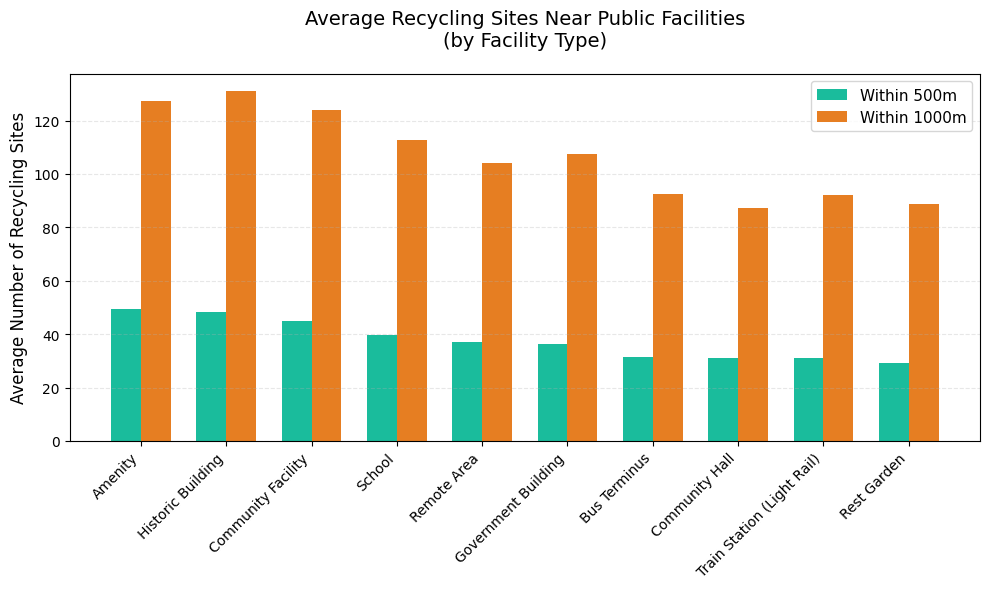

Saved updated figure (full English names) to: /content/drive/MyDrive/Colab Notebooks/data/Recycling Convenience by Facility Type.png


,facility_type,avg_500,avg_1000
0,Amenity,49.6,127.5
1,Historic Building,48.4,131.0
2,Community Facility,45.1,123.8
3,School,39.7,112.8
4,Remote Area,37.0,104.1
5,Government Building,36.4,107.6
6,Bus Terminus,31.6,92.4
7,Community Hall,31.1,87.4
8,Train Station (Light Rail),31.0,92.0
9,Rest Garden,29.4,88.8


In [31]:
sql_class_stats = """
WITH facility_counts AS (
    SELECT
        sf_id,
        SUM(CASE WHEN within_500  THEN 1 ELSE 0 END) AS count_500,
        SUM(CASE WHEN within_1000 THEN 1 ELSE 0 END) AS count_1000
    FROM pairs_buffer
    GROUP BY sf_id
)
SELECT
    CASE f.class
        WHEN 'PAK' THEN 'Park'
        WHEN 'AQU' THEN 'Swimming Pool'
        WHEN 'BGD' THEN 'Beach / Garden'
        WHEN 'BUS' THEN 'Bus Terminus'
        WHEN 'RSF' THEN 'Rest Garden'
        WHEN 'COM' THEN 'Community Hall'
        WHEN 'CMF' THEN 'Community Facility'
        WHEN 'CUF' THEN 'Cultural Facility'
        WHEN 'GOV' THEN 'Government Building'
        WHEN 'HNC' THEN 'Historic Building'
        WHEN 'MUF' THEN 'Museum'
        WHEN 'REM' THEN 'Remote Area'
        WHEN 'SCH' THEN 'School'
        WHEN 'TRF' THEN 'Traffic Facility'
        WHEN 'TRH' THEN 'Train Station (MTR)'
        WHEN 'TRS' THEN 'Train Station (Light Rail)'
        WHEN 'AMD' THEN 'Amenity'
        WHEN 'UTI' THEN 'Utility Facility'
        ELSE f.class || ' (Unknown)'
    END AS facility_type,
    ROUND(AVG(fc.count_500), 2)              AS avg_sites_500m,
    ROUND(AVG(fc.count_1000), 2)             AS avg_sites_1000m,
    ROUND(AVG(CASE WHEN fc.count_500  > 0 THEN 100.0 ELSE 0.0 END), 1) || '%' AS coverage_500m,
    ROUND(AVG(CASE WHEN fc.count_1000 > 0 THEN 100.0 ELSE 0.0 END), 1) || '%' AS coverage_1000m,
    COUNT(*)                                 AS total_facilities
FROM facility_counts fc
JOIN public_facilities f ON fc.sf_id = f.sf_id
GROUP BY f.class
ORDER BY avg_sites_500m DESC;
"""

class_stats = pd.read_sql_query(sql_class_stats, conn)
print("Recycling Convenience by Facility Type:")
display(class_stats)


top_classes = class_stats.head(10)

x = np.arange(len(top_classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, top_classes['avg_sites_500m'], width, label='Within 500m', color='#1abc9c')
plt.bar(x + width/2, top_classes['avg_sites_1000m'], width, label='Within 1000m', color='#e67e22')

plt.xticks(x, top_classes['facility_type'], rotation=45, ha='right', fontsize=10)
plt.ylabel("Average Number of Recycling Sites", fontsize=12)
plt.title("Average Recycling Sites Near Public Facilities\n(by Facility Type)", fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

fac_fig_path = dataPath + "Recycling Convenience by Facility Type.png"
plt.savefig(fac_fig_path, dpi=200, bbox_inches='tight')
plt.show()

print("Saved updated figure (full English names) to:", fac_fig_path)


class_stats['avg_500']  = class_stats['avg_sites_500m'].round(1)
class_stats['avg_1000'] = class_stats['avg_sites_1000m'].round(1)
display(class_stats[['facility_type', 'avg_500', 'avg_1000']])

## Recycling Points vs Public Facilities per District


Pearson correlation (district-level): r = 0.281


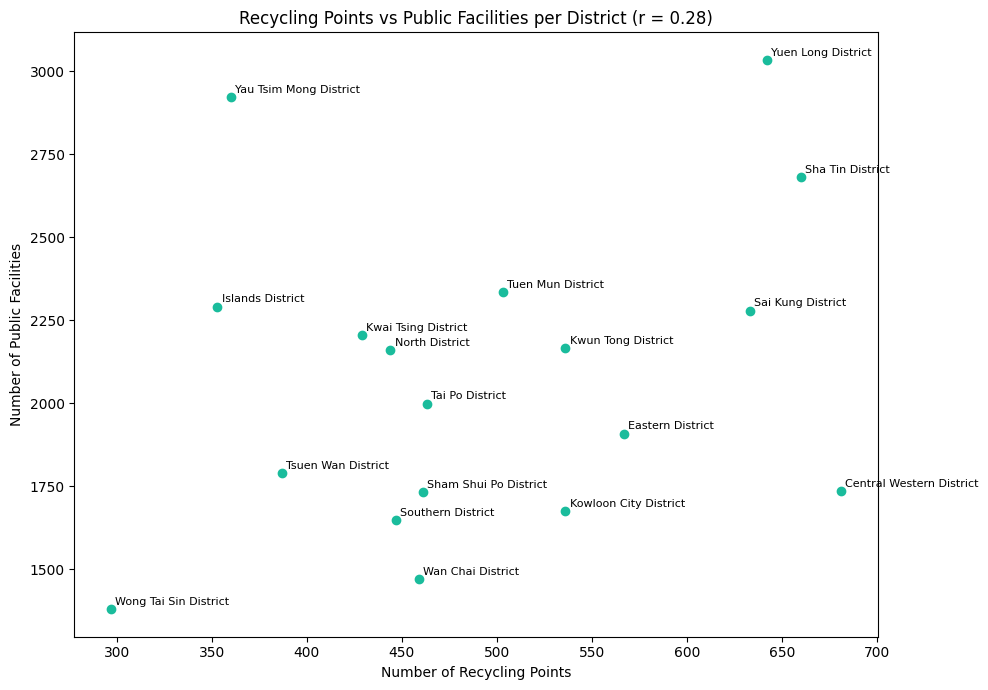

Saved correlation figure to: /content/drive/MyDrive/Colab Notebooks/data/Recycling Points vs Public Facilities per District.png


,district,recycling_count,facilities_count
0,Central Western District,681,1735
1,Eastern District,567,1909
2,Islands District,353,2291
3,Kowloon City District,536,1676
4,Kwai Tsing District,429,2205
5,Kwun Tong District,536,2165
6,North District,444,2161
7,Sai Kung District,633,2279
8,Sha Tin District,660,2682
9,Sham Shui Po District,461,1732


In [32]:
corr = summary['recycling_points'].corr(summary['facilities'])
print(f"\nPearson correlation (district-level): r = {corr:.3f}")


plt.figure(figsize=(10,7))
plt.scatter(summary['recycling_points'], summary['facilities'], color='#1abc9c')

for dist, row in summary.iterrows():
    plt.annotate(dist, (row['recycling_points'], row['facilities']),
                 fontsize=8, xytext=(3,3), textcoords='offset points')

plt.xlabel("Number of Recycling Points")
plt.ylabel("Number of Public Facilities")
plt.title(f"Recycling Points vs Public Facilities per District (r = {corr:.2f})")
plt.tight_layout()

corr_fig_path = dataPath + "Recycling Points vs Public Facilities per District.png"
plt.savefig(corr_fig_path, dpi=150)

plt.show()
print("Saved correlation figure to:", corr_fig_path)


summary['recycling_count']   = summary['recycling_points'].astype(int)
summary['facilities_count']  = summary['facilities'].astype(int)
summary_with_district = summary.reset_index()
display(summary_with_district[['district', 'recycling_count', 'facilities_count']])

cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS pairs_dist;")
cur.execute("DROP TABLE IF EXISTS pairs_buffer;")
conn.commit()

## Report html

In [33]:
import os
import shutil
import json

report_dir = f"{dataPath}/Reports_html"
image_dir = os.path.join(report_dir, "images")
os.makedirs(image_dir, exist_ok=True)


for img in [
    "Coverage of Different Waste Types Across Recycling Sites.png",
    "Average Distance from Public Facility to Nearest Recycling Site by District.png",
    "Recycling Convenience by Facility Type.png",
    "Recycling Points vs Public Facilities per District.png"
]:
    src = f"{dataPath}/{img}"
    if os.path.exists(src):
        shutil.copy2(src, image_dir)

HTML_TEMPLATE = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>{title}</title>
    <style>
        body {font-family: 'Segoe UI', Arial, sans-serif; background: #f8fff9; color: #2c3e50; line-height: 1.7; margin: 0; padding: 40px 20px;}
        .container {max-width: 1000px; margin: 0 auto; background: white; padding: 50px; border-radius: 16px; box-shadow: 0 10px 30px rgba(0,0,0,0.1); border-left: 6px solid #1abc9c;}
        h1 {color: #1abc9c; text-align: center; font-size: 36px; margin-bottom: 10px;}
        h2 {color: #1abc9c; text-align: center; font-size: 22px; margin: 40px 0 20px;}
        select {width: 100%; padding: 16px; font-size: 17px; border: 2px solid #ddd; border-radius: 10px; margin: 20px 0;}
        .report {margin: 40px 0; padding: 30px; background: #f8fff9; border-left: 6px solid #1abc9c; border-radius: 10px; font-size: 19px; display: none;}
        .highlight {color: #e67e22; font-weight: bold;}
        .chart {text-align: center; margin: 50px 0;}
        .chart img {max-width: 100%; border-radius: 12px; box-shadow: 0 8px 25px rgba(0,0,0,0.15);}
        .back {display: block; width: 300px; margin: 50px auto; padding: 16px; background: #1abc9c; color: white; text-align: center; text-decoration: none; border-radius: 10px; font-weight: bold;}
        .back:hover {background: #16a085;}
        footer {text-align: center; margin-top: 80px; color: #7f8c8d; font-size: 14px;}
    </style>
</head>
<body>
    <div class="container">
        <h1>Smart Green Recycling Navigator</h1>
        <h2>{page_title}</h2>
        <select id="selector" onchange="showReport()">
            <option value="">-- Select an option to generate a report --</option>
            {options}
        </select>
        <div id="report" class="report"></div>
        <div class="chart">
            <img src="images/{image}" alt="Chart">
        </div>
        <a href="../index.html" class="back">Return to Homepage</a>
    </div>
    <footer>Smart Green Recycling Navigator Team • AIDM7360 Group Project • November 2025</footer>

    <script>
        const reports = {reports_json};

        function showReport() {
            const sel = document.getElementById("selector");
            const idx = sel.selectedIndex - 1;
            const output = document.getElementById("report");
            if (idx >= 0) {
                output.innerHTML = reports[idx];
                output.style.display = "block";
            } else {
                output.style.display = "none";
            }
        }
    </script>
</body>
</html>"""


reports_config = [
    {
        "file": "01_Waste_Type_Coverage.html",
        "title": "Waste Type Coverage Analysis",
        "image": "Coverage of Different Waste Types Across Recycling Sites.png",
        "options": "\n".join(
            f'<option>{row.waste_type} </option>'
            for row in df_waste.itertuples()
        ),
        "texts": [
            f"In our dataset, <strong class='highlight'>{row.waste_type}</strong> accounts for about <strong class='highlight'>{row.share_pct:.1f}%</strong> of all recorded recycling-capacity entries across sites."
            for row in df_waste.itertuples()
        ]
    },
    {
        "file": "02_District_Distance.html",
        "title": "District Average Distance Analysis",
        "image": "Average Distance from Public Facility to Nearest Recycling Site by District.png",
        "options": "\n".join(
            f'<option>{row.district} </option>'
            for row in df_avg_dist.itertuples()
        ),
        "texts": [
            f"In <strong class='highlight'>{row.district}</strong>, public facilities are on average about <strong class='highlight'>{int(row.avg_distance)}</strong> meters away from the nearest recycling site."
            for row in df_avg_dist.itertuples()
        ]
    },
    {
        "file": "03_Facility_Class_Convenience.html",
        "title": "Facility Class Convenience Analysis",
        "image": "Recycling Convenience by Facility Type.png",
        "options": "\n".join(
            f'<option>{row.facility_type}</option>'
            for row in class_stats.itertuples()
        ),
        "texts": [
            f"For <strong class='highlight'>{row.facility_type}</strong>, there are on average <strong class='highlight'>{row.avg_500:.1f}</strong> recycling sites within 500 meters and <strong class='highlight'>{row.avg_1000:.1f}</strong> within 1 kilometer."
            for row in class_stats.itertuples()
        ]
    },
    {
        "file": "04_District_Correlation.html",
        "title": "District Recycling & Facilities Analysis",
        "image": "Recycling Points vs Public Facilities per District.png",
        "options": "\n".join(
            f'<option>{row.district}</option>'
            for row in summary.reset_index().itertuples()
        ),
        "texts": [
            f"In <strong class='highlight'>{row.district}</strong>, there are <strong class='highlight'>{row.recycling_count}</strong> recycling points and <strong class='highlight'>{row.facilities_count}</strong> public facilities."
            for row in summary.reset_index().itertuples()
        ]
    }
]


for config in reports_config:
    html = HTML_TEMPLATE.replace("{title}", config["title"]) \
                        .replace("{page_title}", config["title"]) \
                        .replace("{image}", config["image"]) \
                        .replace("{options}", config["options"]) \
                        .replace("{reports_json}", json.dumps(config["texts"]))

    filepath = os.path.join(report_dir, config["file"])
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(html)

print("path：", report_dir)

path： /content/drive/MyDrive/Colab Notebooks/data//Reports_html


# Homepage html

In [25]:
import os
import shutil

def generate_perfect_english_index():
    html = '''<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Smart Green Recycling Navigator</title>
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700;800&display=swap" rel="stylesheet">
    <style>
        :root {
            --green: #1abc9c;
            --green-dark: #16a085;
            --blue: #3498db;
            --dark: #2c3e50;
            --light: #f8fff9;
            --gray: #95a5a6;
        }
        * {margin:0;padding:0;box-sizing:border-box;}
        body {
            font-family:'Poppins',sans-serif;
            background:var(--light);
            color:var(--dark);
            line-height:1.7;
        }
        header {
            background:linear-gradient(135deg,var(--green),var(--green-dark));
            color:white;
            text-align:center;
            padding:120px 20px;
        }
        h1 {
            font-size:56px;
            font-weight:800;
            letter-spacing:-1px;
        }
        .container {
            max-width:1400px;
            margin:0 auto;
            padding:80px 40px;
        }

        /* Three main cards — forced 3-column layout */
        .features {
            display:grid;
            grid-template-columns: repeat(3, 1fr);
            gap:40px;
            margin-bottom:120px;
        }
        @media (max-width:1100px) {
            .features {grid-template-columns:1fr;}
        }
        .card {
            background:white;
            border-radius:28px;
            padding:50px 30px;
            text-align:center;
            box-shadow:0 20px 60px rgba(0,0,0,0.12);
            transition:all 0.4s ease;
            height:100%;
            display:flex;
            flex-direction:column;
            justify-content:space-between;
        }
        .card:hover {
            transform:translateY(-20px);
            box-shadow:0 35px 80px rgba(0,0,0,0.2);
        }
        .icon {
            font-size:90px;
            margin-bottom:20px;
        }
        .card h3 {
            font-size:28px;
            font-weight:700;
            margin:20px 0;
            color:var(--dark);
        }
        .card p {
            color:#666;
            font-size:17px;
            flex-grow:1;
            margin-bottom:30px;
        }
        .btn {
            display:inline-block;
            padding:18px 40px;
            border-radius:16px;
            font-weight:700;
            font-size:18px;
            text-decoration:none;
            transition:all 0.3s;
            width:80%;
            margin:0 auto;
        }
        .btn-green {
            background:var(--green);
            color:white;
        }
        .btn-green:hover {
            background:var(--green-dark);
            transform:scale(1.05);
        }
        .btn-blue {
            background:var(--blue);
            color:white;
        }
        .btn-blue:hover {
            background:#2980b9;
            transform:scale(1.05);
        }

        /* Four interactive reports — forced 4-column layout */
        .reports-section {
            margin-top:100px;
        }
        .reports-section h2 {
            text-align:center;
            color:var(--green);
            font-size:42px;
            font-weight:800;
            margin-bottom:70px;
        }
        .reports-grid {
            display:grid;
            grid-template-columns: repeat(4, 1fr);
            gap:35px;
        }
        @media (max-width:1200px) {
            .reports-grid {grid-template-columns: repeat(2, 1fr);}
        }
        @media (max-width:768px) {
            .reports-grid {grid-template-columns: 1fr;}
        }
        .report-card {
            background:white;
            border-radius:20px;
            padding:35px 25px;
            text-align:center;
            box-shadow:0 15px 40px rgba(0,0,0,0.1);
            transition:all 0.4s;
            border-left:8px solid var(--green);
            height:100%;
            display:flex;
            flex-direction:column;
            justify-content:space-between;
        }
        .report-card:hover {
            transform:translateY(-12px);
            box-shadow:0 25px 50px rgba(0,0,0,0.18);
        }
        .report-card h4 {
            color:var(--green);
            font-size:21px;
            font-weight:700;
            margin-bottom:15px;
        }
        .report-card p {
            color:#666;
            font-size:15.5px;
            margin-bottom:20px;
            flex-grow:1;
        }
        .report-card a {
            color:var(--green);
            font-weight:700;
            font-size:17px;
            text-decoration:none;
            padding:12px 20px;
            border:2px solid var(--green);
            border-radius:12px;
            display:inline-block;
            transition:all 0.3s;
        }
        .report-card a:hover {
            background:var(--green);
            color:white;
        }

        footer {
            background:var(--dark);
            color:#bdc3c7;
            text-align:center;
            padding:70px 20px;
            margin-top:150px;
            font-size:16px;
        }
        footer strong {color:white;}
    </style>
</head>
<body>

<header>
    <h1>Smart Green Recycling Navigator</h1>
</header>

<div class="container">

    <!-- Three main feature cards (Map + Two Search Systems) -->
    <div class="features">
        <div class="card">
            <div class="icon">Map</div>
            <h3>Interactive Recycling Map</h3>
            <p>Folium multi-layer interactive map with waste type filtering and public facility overlay</p>
            <a href="Hong_Kong_Recycling_Map.html" target="_blank" class="btn btn-green">Launch Map</a>
        </div>

        <div class="card">
            <div class="icon">Search</div>
            <h3>Nearby Facility Search System</h3>
            <p>Find recycling points by nearby public facilities</p>
            <a href="Smart_Recycling_Finder__By_Nearby_Facility.html" target="_blank" class="btn btn-blue">Open System</a>
        </div>

        <div class="card">
            <div class="icon">Search</div>
            <h3>Waste Category Search System</h3>
            <p>Find recycling points by waste type</p>
            <a href="Smart_Recycling_Finder__By_Waste_Category.html" target="_blank" class="btn btn-blue">Open System</a>
        </div>
    </div>

    <!-- Four Interactive Automated Reports -->
    <div class="reports-section">
        <h2>Interactive Automated Reports (Select to Generate)</h2>
        <div class="reports-grid">
            <div class="report-card">
                <h4>01 Waste Type Coverage Analysis</h4>
                <p>Select any waste type → instantly view network coverage percentage</p>
                <a href="Reports_html/01_Waste_Type_Coverage.html" target="_blank">Open Report</a>
            </div>
            <div class="report-card">
                <h4>02 District Accessibility Analysis</h4>
                <p>Select district → view average distance to nearest recycling point</p>
                <a href="Reports_html/02_District_Distance.html" target="_blank">Open Report</a>
            </div>
            <div class="report-card">
                <h4>03 Facility Class Convenience Analysis</h4>
                <p>Select facility type → compare recycling sites within 500m vs 1000m</p>
                <a href="Reports_html/03_Facility_Class_Convenience.html" target="_blank">Open Report</a>
            </div>
            <div class="report-card">
                <h4>04 District Infrastructure Comparison</h4>
                <p>Select district → compare recycling points vs public facilities</p>
                <a href="Reports_html/04_District_Correlation.html" target="_blank">Open Report</a>
            </div>
        </div>
    </div>

</div>

<footer>
    <p><strong>Smart Green Recycling Navigator</strong> • November 2025</p>
    <p><em>Making Hong Kong a Greener City Through Data Intelligence</em></p>
</footer>

</body>
</html>'''

    root_path = "/content/drive/MyDrive/Colab Notebooks/data"
    index_path = os.path.join(root_path, "index.html")

    with open(index_path, 'w', encoding='utf-8') as f:
        f.write(html)

    report_folder = os.path.join(root_path, "Reports_html")
    if os.path.exists(report_folder):
        shutil.copy2(index_path, os.path.join(report_folder, "index.html"))

    print("Homepage generated successfully!")
    print("Path:", index_path)

# Run immediately
generate_perfect_english_index()

Homepage generated successfully!
Path: /content/drive/MyDrive/Colab Notebooks/data/index.html


# Declaration

I did  knowingly use generative AI tools in this assignment task

## Acknowledgment
If you did use any generative AI tools, please complete the following acknowledgment:

* **Process**: In my assignment preparation, I acknowledge the use of generative AI tools to help generate topic suggestions, explain Python syntax, create and interpret HTML code, correct errors and find the most appropriate solution.

* **Record**: I have kept a record of my use of AI tools, including the specific tool(s) used, the prompts submitted, and responses generated.

I understand that my teachers may ask me to provide this information.

# Appendix
Report below your prompts with a brief description of their usage.

- **Prompt**: "Why is there a `nan` value (text) in the `district` column of the `districts` table in the output DB, even though there is no `nan` in the original CSV?"
  **Usage**: Asked why a `NaN` value appeared in the database even though the original CSV contained no `NaN`, leading to explanation about how `astype(str)` converts `NaN` to the string `"nan"` and gets inserted.

- **Prompt**: "There is a value 'Central & Western District' in the E_DISTRICT column of the facility CSV; I want to remove the '&' before inserting it."
  **Usage**: Requested string cleaning method for removing the `&` symbol before inserting district names into SQLite.

- **Prompt**: "I want to handle the cleaning of E_DISTRICT inside convert_coordinates()."
  **Usage**: Asked how to integrate district name preprocessing (remove `&`, strip spaces) into the coordinate conversion pipeline.

- **Prompt**: "Help me modify insert_districts so that `district_id` is auto-generated, and `district` is inserted from the CSV's E_DISTRICT."
  **Usage**: Requested modification of SQL insert logic to use auto-generated primary keys and insert cleaned district names.

- **Prompt**: "There is a None value in the district column of the districts table in the output DB — help me modify insert_districts."
  **Usage**: Asked for a method to filter out `None`, `"nan"`, and empty strings so they don’t get inserted into the district table.

- **Prompt**: “Can the final print follow the exact output format of report_templates? Modify only that part of the code, don’t change anything else.”
  **Usage**: Requested minimal changes only to the final print block to perfectly display the 9 stored report templates in a clean 3-column layout.

- **Prompt**: “I want to change your original ‘recreate templates table’ code so that it only creates the table when it does NOT exist, and never drops it.”
  **Usage**: Required a safe, idempotent version of the report_templates creation code using `CREATE TABLE IF NOT EXISTS` and `INSERT OR IGNORE` to prevent unintended table drops and data loss.

- **Prompt**: “Replace the footer text ‘Smart Green Recycling Navigator Team • November 2025 …’ with a version that uses ‘AIDM7360 Group Project’ and an italic subtitle.”
  **Usage**: Updated the footer text in index.html to the required final version with “AIDM7360 Group Project” and an italic subtitle.

- **Prompt**: “Help me change this title to a green background (#18AC8F) with white text, do not touch anything else.”
  **Usage**: Converted the centered h3 title into a solid #18AC8F green background with pure white text while keeping all original fonts and layout intact.

- **Prompt**: “Summarize my map functionality in one simple paragraph” + provided Folium code
  **Usage**: Requested a concise, professional English description of the multi-layer interactive Folium map for use in the report and presentation.

- **Prompt**: Full draft script + “Fix my grammar with minimal changes”
  **Usage**: Requested final grammar polishing and light fluency editing of a complete 1-minute presentation script while keeping original meaning and tone.

- **Prompt**: “KeyError: 'date' happened again, remove everything related to date” → later “Actually keep the date, help me fix it”
  **Usage**: Went through the full cycle of removing datetime → reverting → restoring datetime support, ultimately resolving KeyErrors caused by mismatched template placeholders.

- **Prompt**: Multiple times provided full code + “Only modify this tiny block, do not touch anything else.”
  **Usage**: Required precise, minimal-intrusion code modifications, keeping the existing structure and changing only the specific part causing errors or required by the instructor.